# Survival Regression

In this notebook, we use `TorchSurv` to train a model that predicts relative risk of breast cancer recurrence. We use a public data set, the [German Breast Cancer Study Group 2 (GBSG2)](https://paperswithcode.com/dataset/gbsg2). After training the model, we evaluate the predictive performance using evaluation metrics implemented in `TorchSurv`.

We first load the dataset using the package [lifelines](https://lifelines.readthedocs.io/en/latest/). The GBSG2 dataset contains features and recurrence free survival time (in days) for 686 women undergoing hormonal treatment. 

### 1. Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our development conda environment (**preferred**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependencies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import lifelines
import pandas as pd
import torch

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_introduction import Custom_dataset, plot_losses
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Our package
from torchsurv.loss import cox, weibull
from torchsurv.metrics.auc import Auc
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex

In [4]:
# Issue with eager mode
# torch._dynamo.config.suppress_errors = True  # Suppress inductor errors
# torch._dynamo.reset()  # Reset the backend

In [5]:
# Constant parameters across models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

CUDA-enabled GPU/TPU is available.


### 2. Dataset

In [6]:
# Load GBSG2 dataset
df = lifelines.datasets.load_gbsg2()
df.head(5)

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


The dataset contains the features: 

- `horTh`: hormonal therapy, a factor at two levels (yes and no).
- `age`:  age of the patients in years.
- `menostat`: menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- `tsize`: tumor size (in mm).
- `tgrade`: tumor grade, a ordered factor at levels I < II < III.
- `pnodes`: number of positive nodes.
- `progrec`: progesterone receptor (in fmol).
- `estrec`: estrogen receptor (in fmol).

Additionally, it contains our survival targets:

- `time`: recurrence free survival time (in days).
- `cens`: event indicator (0- censored, 1- event).

One common approach is to use a [one hot encoder](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert them into numerical features. We then separate the dataframes into features `X` and labels `y`. The following code also partitions the labels and features into training and testing cohorts.

Data preparation:

In [7]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
0,70.0,21.0,3.0,48.0,66.0,1814.0,1.0,0.0,0.0,1.0,0.0
1,56.0,12.0,7.0,61.0,77.0,2018.0,1.0,1.0,0.0,1.0,0.0
2,58.0,35.0,9.0,52.0,271.0,712.0,1.0,1.0,0.0,1.0,0.0
3,59.0,17.0,4.0,60.0,29.0,1807.0,1.0,1.0,0.0,1.0,0.0
4,73.0,35.0,1.0,26.0,65.0,772.0,1.0,0.0,0.0,1.0,0.0


In [8]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}")

(Sample size) Training:336 | Validation:144 |Testing:206


Let us setup the dataloaders for training, validation and testing.

In [9]:
# Dataloader
dataloader_train = DataLoader(Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(Custom_dataset(df_val), batch_size=len(df_val), shuffle=False)
dataloader_test = DataLoader(Custom_dataset(df_test), batch_size=len(df_test), shuffle=False)

In [10]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([128, 9])
num_features = 9
event        = torch.Size([128])
time         = torch.Size([128])


### 3. Cox Model

In this section, we use the [Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariates $x_{i}$, a vector of size $p$, the hazard of patient $i$ has the form
$$
\lambda_i (t) =\lambda_{0}(t)\: \theta_i
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurrence is captured through the relative hazards $\{\theta_i\}_{i = 1, \dots, N}$. 

In the traditional Cox proportional hazards model, the log relative hazards are modeled as a linear combination of covariates: i.e., $\log \theta_i = x_{i}^T \beta$. In contrast, we allow the log relative hazards $\log \theta_i$ to be modeled by a neural network. For example, here we train a multi-layer perceptron (MLP) to model the log relative hazards $\log\theta_i$. Patients with lower recurrence time are assumed to have higher risk of event. 

#### 3.1. MLP model for log relative hazards

In [11]:
# Initiate Cox model
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

#### 3.2. Model training

In [12]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = cox.neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record loss on train and test sets
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(cox.neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean"))

Epoch: 000, Training loss: 12.93
Epoch: 010, Training loss: 12.25
Epoch: 020, Training loss: 12.37
Epoch: 030, Training loss: 12.41
Epoch: 040, Training loss: 11.73
Epoch: 050, Training loss: 11.73
Epoch: 060, Training loss: 12.08
Epoch: 070, Training loss: 11.79
Epoch: 080, Training loss: 11.82
Epoch: 090, Training loss: 11.84


We can visualize the training and validation losses.

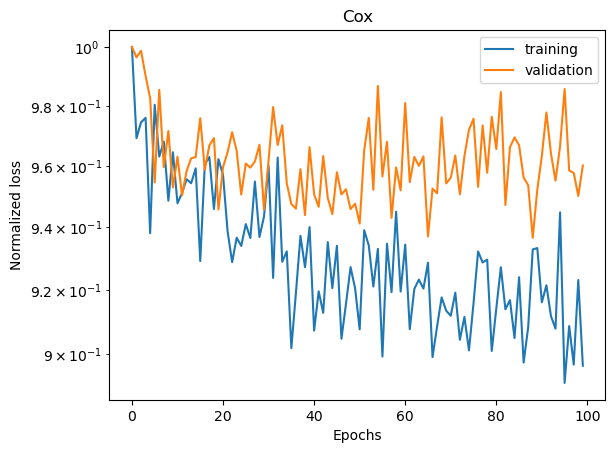

In [13]:
plot_losses(train_losses, val_losses, "Cox")

#### 3.3. Evaluation metrics

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

For the Cox model, to estimate the survival function on the test set, we first need to estimate the baseline survival function on the training set:

In [14]:
cox_model.eval()
with torch.no_grad():
    x, (event, time) = next(iter(dataloader_train))
    log_hz = cox_model(x)  # log hazard on train set
    baseline_surv = cox.baseline_survival_function(log_hz, event, time)  # baseline survival function

We then evaluate the subject-specific relative hazards and on the survival function on the test set 

In [15]:
with torch.no_grad():
    # test event and test time of length n
    test_x, (test_event, test_time) = next(iter(dataloader_test))
    test_log_hz = cox_model(test_x)  # log hazard of length n

# Compute the survival probability
test_surv = cox.survival_function_cox(baseline_surv, test_log_hz, test_time)  # shape = (n,n)

We obtain the concordance index, and its confidence interval

In [16]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(test_log_hz, test_event, test_time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.6270062923431396
Confidence interval = tensor([0.5053, 0.7488])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [17]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.020449936389923096


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [18]:
cox_auc = Auc()

new_time = torch.tensor(1825.0)

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {cox_auc(test_log_hz, test_event, test_time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 5-yr             = tensor([0.6715])
AUC 5-yr (conf int.) = tensor([0.6134, 0.7296])


As before, we can test whether the observed Auc at 5-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [19]:
print(f"AUC (p_value) = {cox_auc.p_value(alternative='greater')}")

AUC (p_value) = tensor([0.])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [20]:
cox_brier_score = BrierScore()

# brier score at last 5 times
print(f"Brier score             = {cox_brier_score(test_surv, test_event, test_time)[-5:]}")
print(f"Brier score (conf int.) = {cox_brier_score.confidence_interval()[:, -5:]}")

# integrated brier score
print(f"Integrated Brier score  = {cox_brier_score.integral()}")

Brier score             = tensor([0.0583, 0.0537, 0.0507, 0.0487, 0.0477])
Brier score (conf int.) = tensor([[0.0402, 0.0377, 0.0356, 0.0340, 0.0331],
        [0.0764, 0.0698, 0.0657, 0.0633, 0.0623]])
Integrated Brier score  = 0.12022337317466736


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [21]:
# H0: bs = bs0, Ha: bs < bs0;
# where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at last 5 times
print(f"Brier score (p-val)        = {cox_brier_score.p_value(alternative='less')[-5:]}")

Brier score (p-val)        = tensor([0.0110, 0.0030, 0.0030, 0.0030, 0.0030])


### 4. Weibull Model

In this section, we use the [Weibull model](../_autosummary/torchsurv.loss.weibull.html). Given covariates $x_{i}$, a vector of size $p$, the hazard of patient $i$ has the form
$$
h_i (t) = \frac{\rho_i}{\lambda_i}\left(\frac{t}{\lambda_i} \right)^{\rho_i}
$$
The subject-specific risk of event occurrence are captured through the shape and scale parameters $\{(\lambda_i, \rho_i)\}_{i = 1, \dots, N}$. 

In the traditional Weibull AFT, the log parameters are modeled as a linear combination of covariates: i.e., $\log \lambda_i = x_{i}^T \beta_{\lambda}$, $\log \rho_i = x_{i}^T \beta_{\rho}$. In contrast, we allow the rlog parameters $(\log \lambda_i,\log \rho_i)$ to be modeled by a neural network. For example, here we train a multi-layer perceptron (MLP) to model the log parameters $(\log \lambda_i,\log \rho_i)$. Patients with lower recurrence time are assumed to have higher risk of event. 

#### 4.1. MLP model for log scale and log shape

In [22]:
# Same architecture than Cox model, beside outputs dimension
weibull_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 2),  # Estimating log parameters for Weibull model
)

#### 4.2. Model training

In [23]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(weibull_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_params = weibull_model(x)  # shape = (16, 2)
        loss = weibull.neg_log_likelihood_weibull(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(weibull.neg_log_likelihood_weibull(weibull_model(x), event, time, reduction="mean"))

Epoch: 000, Training loss: 1851.53
Epoch: 010, Training loss: 18.00
Epoch: 020, Training loss: 18.71
Epoch: 030, Training loss: 19.56
Epoch: 040, Training loss: 18.13
Epoch: 050, Training loss: 17.43
Epoch: 060, Training loss: 17.57
Epoch: 070, Training loss: 17.78
Epoch: 080, Training loss: 16.48
Epoch: 090, Training loss: 17.01


We can visualize the training and validation losses.

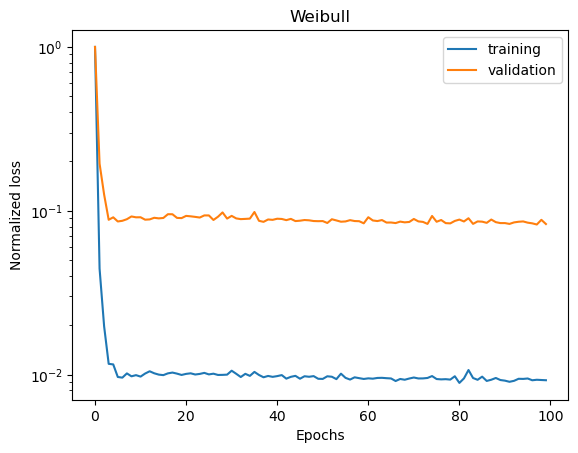

In [24]:
plot_losses(train_losses, val_losses, "Weibull")

#### 4.3. Evaluation Metrics

As for the Cox Model, we evaluate the predictive performance of the model using the [C-index](../_autosummary/torchsurv.metrics.cindex.html), the [AUC](../_autosummary/torchsurv.metrics.auc.html) and the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html).

We start by obtaining the subject-specific log hazard and survival probability at every time $t$ observed on the test set

In [25]:
weibull_model.eval()
with torch.no_grad():
    # event and time of length n
    test_x, (test_event, test_time) = next(iter(dataloader_test))
    test_log_params = weibull_model(test_x)  # shape = (n,2)

# Compute the log hazards from weibull log parameters
test_log_hz = weibull.log_hazard(test_log_params, test_time)  # shape = (n,n)

# Compute the survival probability from weibull log parameters
test_surv = weibull.survival_function_weibull(test_log_params, test_time)  # shape = (n,n)

We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [26]:
# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(test_log_hz, test_event, test_time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative='greater')}")

Weibull model performance:
Concordance-index   = 0.5810908079147339
Confidence interval = tensor([0.4549, 0.7073])
p-value             = 0.10387903451919556


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [27]:
new_time = torch.tensor(1825.0)

# subject-specific log hazard at 5-yr
log_hz_t = weibull.log_hazard(test_log_params, new_time=new_time)  # shape = (n)
weibull_auc = Auc()

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {weibull_auc(log_hz_t, test_event, test_time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {weibull_auc.confidence_interval()}")
print(f"AUC 5-yr (p value)   = {weibull_auc.p_value(alternative='greater')}")

AUC 5-yr             = tensor([0.5771])
AUC 5-yr (conf int.) = tensor([0.5232, 0.6310])
AUC 5-yr (p value)   = tensor([0.0025])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [28]:
weibull_brier_score = BrierScore()

# brier score at last 5 times
print(f"Brier score             = {weibull_brier_score(test_surv, test_event, test_time)[-5:]}")
print(f"Brier score (conf int.) = {weibull_brier_score.confidence_interval()[:, -5:]}")

# integrated brier score
print(f"Integrated Brier score  = {weibull_brier_score.integral()}")

# p-value for brier score at first 5 times
print(f"Brier score (p-val)        = {weibull_brier_score.p_value(alternative='less')[-5:]}")

Brier score             = tensor([0.0506, 0.0476, 0.0450, 0.0426, 0.0403])
Brier score (conf int.) = tensor([[0.0394, 0.0379, 0.0365, 0.0351, 0.0339],
        [0.0618, 0.0574, 0.0536, 0.0501, 0.0468]])
Integrated Brier score  = 0.22017250955104828
Brier score (p-val)        = tensor([0.3780, 0.1040, 0.0620, 0.0550, 0.0760])


### 5. Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Weibull AFT model.

#### Comparing the Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex weibull, Ha: cindex cox > cindex weibull

In [29]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Weibull cindex = {weibull_cindex.cindex}")
print(f"p-value        = {cox_cindex.compare(weibull_cindex)}")

Cox cindex     = 0.6270062923431396
Weibull cindex = 0.5810908079147339
p-value        = 0.24964120984077454


#### Comparing the AUC at 5-year

The statistical test is formulated as follows, H0: 5-yr auc cox = 5-yr auc weibull, Ha: 5-yr auc cox > 5-yr auc weibull

In [30]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Weibull 5-yr AUC = {weibull_auc.auc}")
print(f"p-value          = {cox_auc.compare(weibull_auc)}")

Cox 5-yr AUC     = tensor([0.6715])
Weibull 5-yr AUC = tensor([0.5771])
p-value          = tensor([0.0002])


#### Comparing the Brier-Score at 5-year

The statistical test is formulated as follows, H0: 5-yr bs cox = 5-yr bs weibull, Ha: 5-yr bs cox > 5-yr bs weibull

In [31]:
print(f"Cox 5-yr BS     = {cox_brier_score.brier_score[-1]}")
print(f"Weibull 5-yr BS = {weibull_brier_score.brier_score[-1]}")
print(f"p-value          = {cox_brier_score.compare(weibull_brier_score)[-1]}")

Cox 5-yr BS     = 0.047671522945165634
Weibull 5-yr BS = 0.04033886268734932
p-value          = 0.8887996673583984
